In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Create Dataset for Training


In [ ]:
import tarfile
import os

def extract(tar_url, extract_path='.'):
    print(tar_url)
    tar = tarfile.open(tar_url, 'r')
    for item in tar:
        tar.extract(item, extract_path)
        if item.name.find(".tgz") != -1 or item.name.find(".tar") != -1:
            extract(item.name, "./" + item.name[:item.name.rfind('/')])


In [ ]:
reports_tgz = "/content/drive/MyDrive/ChestXAI/dataset/reports/NLMCXR_reports.tgz"

if len(os.listdir("/content/drive/MyDrive/ChestXAI/dataset/reports/")) ==1:
  extract(tar_url=reports_tgz,extract_path="/content/drive/MyDrive/ChestXAI/dataset/reports")

In [ ]:

images_tgz = "/content/drive/MyDrive/ChestXAI/dataset/images/NLMCXR_png.tgz"
if len(os.listdir("/content/drive/MyDrive/ChestXAI/dataset/images/")) == 1:
  extract(tar_url=images_tgz,extract_path="/content/drive/MyDrive/ChestXAI/dataset/images")

In [ ]:
import csv
import os
import string
from pickle import dump, load
from xml.etree import ElementTree as ET

import numpy as np
import pandas as pd
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.utils import load_img, img_to_array


In [ ]:
class DatasetCreator:
    def __init__(self, reports_filepath: str, images_filepath: str, dataset_filepath: str):
        self.reports_filepath = reports_filepath
        self.images_filepath = images_filepath
        self.dataset_filepath = dataset_filepath

    def create_xml_root(self, filepath: str):
        tree = ET.parse(filepath)
        root = tree.getroot()
        return root

    def get_image_ids_in_xml(self, root) -> list:
        img_ids = [list(img.attrib.values())[0] for img in root.iter() if img.tag == 'parentImage']
        return img_ids

    def get_finding_in_xml(self, root) -> str:
        findings = root.find('./MedlineCitation/Article/Abstract/AbstractText[@Label="FINDINGS"]')
        finding = "No Findings" if findings.text is None else findings.text
        return finding

    def write_xml_reports_to_csv(self, row: list, filepath: str):
        with open(filepath, 'a', encoding='utf-8') as f:
            csv.writer(f).writerow(row)

    def convert_xml_to_csv(self):
        print("[INFO] Converting XML files to CSV...")
        with open(self.dataset_filepath, 'w', encoding='utf-8') as f:
            columns = ["ID", "FINDING"]
            csv.writer(f).writerow(columns)

        for curr_file in os.listdir(self.reports_filepath):
            if curr_file.endswith('.xml'):
                filepath = os.path.join(self.reports_filepath,curr_file)
                root = self.create_xml_root(filepath)
                finding = self.get_finding_in_xml(root)
                img_ids = self.get_image_ids_in_xml(root)
                for img_id in img_ids:
                    row = [img_id, finding]
                    self.write_xml_reports_to_csv(row, filepath=self.dataset_filepath)

        print("[OK] Converting XML files to CSV...")
    def to_filter_not_exist_images(self) -> pd.DataFrame:
        print(f"[INFO] Filter Not Exist Images in {self.images_filepath}")
        df = pd.read_csv(self.dataset_filepath)
        print(f"[INFO] Raw Dataset for reports: {df.shape[0]}")
        img_files = list(set(os.listdir(self.images_filepath)))
        df["ID"] = df["ID"].apply(lambda row: row if row.endswith('.png') else row+'.png')
        df = df[df["ID"].isin(img_files)]
        print(f"[INFO] Final Dataset for reports: {df.shape[0]}")
        return df

    def to_clean_findings(self, finding: str) -> str:
        """To Lower all sentence & remove punctuations"""
        finding = finding.lower()
        finding = finding.translate(str.maketrans('', '', string.punctuation))
        finding = f"startseq {finding} endseq"
        return finding

    def extract_an_image_feature(self, model, img_id) -> np.ndarray:
        img_path = img_id if img_id.endswith('.png') else img_id + '.png'
        img_path = os.path.join(self.images_filepath, img_path)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img)
        w, h, ch = img.shape[0], img.shape[1], img.shape[2]
        img = img.reshape((1, w, h, ch))
        img = preprocess_input(img)
        feature = model.predict(img, verbose=0)
        return feature

    def write_pkl(self, data, filename):
        filename = filename if filename.endswith(".pkl") else filename+'.pkl'
        print(f"[INFO] Writing final dataset with image features to {filename}")
        with open(filename, 'wb') as f:
            dump(data, f)
            print(f"[OK] {filename} is saved")

    def load_pkl(self,filepath:str):
       with open(filepath,'rb') as f:
            data = load(f)
            return data

    def create_dataset(self):
        print("[INFO] Creating dataset.")
        if not os.path.exists(self.dataset_filepath):
          self.convert_xml_to_csv()  # create dataset.csv file
          df = self.to_filter_not_exist_images()
          df["FINDING"] = df["FINDING"].apply(lambda row: self.to_clean_findings(finding=row))
          model = VGG19()
          model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
          print("[INFO] Extracting Image Features")
          df["FEATURE"] = df["ID"].apply(lambda row: self.extract_an_image_feature(model=model, img_id=row))
          self.write_pkl(data=df, filename=self.dataset_filepath)



In [ ]:
os.path.exists("/content/drive/MyDrive/ChestXAI/dataset/dataset.pkl")

True

In [ ]:
reports_filepath = "/content/drive/MyDrive/ChestXAI/dataset/reports/ecgen-radiology"
images_filepath = "/content/drive/MyDrive/ChestXAI/dataset/images"
dataset_filepath = "/content/drive/MyDrive/ChestXAI/dataset/dataset.pkl"

dc = DatasetCreator(reports_filepath=reports_filepath,images_filepath=images_filepath,dataset_filepath=dataset_filepath)
dc.create_dataset()

[INFO] Creating dataset.


In [ ]:
df = dc.load_pkl(filepath=dataset_filepath)

In [ ]:
df.head()

,ID,FINDING,FEATURE
0,CXR3738_IM-1867-1001.png,startseq the heart size and mediastinal contou...,"[[0.1446495, 0.0, 0.02514869, 0.0, 2.056616, 0..."
1,CXR3738_IM-1867-2001.png,startseq the heart size and mediastinal contou...,"[[0.0, 0.0, 0.0, 0.0, 1.8109684, 0.12200919, 0..."
2,CXR3756_IM-1880-1001.png,startseq mediastinal contours are normal uncha...,"[[0.0, 0.0, 0.0, 0.0, 0.9965521, 0.0, 0.0, 0.0..."
3,CXR3756_IM-1880-2001.png,startseq mediastinal contours are normal uncha...,"[[0.0, 0.0, 0.0, 0.0, 0.35616684, 0.0, 0.0, 0...."
4,CXR3755_IM-1879-1001.png,startseq heart size upper limits of normal pul...,"[[0.4033414, 0.0, 0.0, 0.0, 1.6015172, 1.24433..."


In [ ]:
type(df.iloc[0]["FEATURE"])

numpy.ndarray

# Preprocess Findings & EDA


In [ ]:
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import  word_tokenize

def decontraction(doc):
  docs = re.sub(r"won't", "will not", doc)
  docs = re.sub(r"can\'t", "can not", docs)
  docs = re.sub(r"n\'t", " not", docs)
  docs = re.sub(r"\'re", " are", docs)
  docs = re.sub(r"\'s", " is", docs)
  docs = re.sub(r"\'d", " would", docs)
  docs = re.sub(r"\'ll", " will", docs)
  docs = re.sub(r"\'t", " not", docs)
  docs = re.sub(r"\'ve", " have", docs)
  docs = re.sub(r"\'m", " am",docs)
  docs = re.sub(r"n\'t", " not", docs)
  docs = re.sub(r"\'re", " are", docs)
  docs = re.sub(r"\'s", " is", docs)
  docs = re.sub(r"\'d", " would", docs)
  docs = re.sub(r"\'ll", " will", docs)
  docs = re.sub(r"\'t", " not", docs)
  docs = re.sub(r"\'ve", " have",docs)
  docs = re.sub(r"\'m", " am", docs)
  docs = re.sub(r"\*+", "abuse", docs)
  return docs

def remove_stopwords(data):
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')# removing the "not" from the stopwords
  all_stopwords.remove('no')
  text_tokens = word_tokenize(data) # tokenizing the sentence into word
  tokens_without_sw = [word for word in text_tokens if not word in all_stopwords]
  return " ".join(tokens_without_sw)

def to_text_preprocess(data):
  clean_text=[]
  for text in data:
    text=text.lower()# making the text in lower case
    text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text
    text=re.sub(r"xxxx","",text)# Removing the irrelavent XXXX words
    text=re.sub(r'xxx',"",text)
    text=re.sub(r'xx',"",text)
    text=re.sub(r'[0-9]',"",text)# Removing the number in text
    text = re.sub(r"yearold", "", text)
    text= re.sub('\s+',' ',text)
    text=re.sub("'",'',text)# Removing apoustahe
    text=re.sub(r'\.\.+', '.',text)# Removing multiple full stop
    text=re.sub(r'  ',"",text)
    text=decontraction(text)
    text=remove_stopwords(text)
    clean_text.append(text)
  return clean_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df["FINDING"] = to_text_preprocess(df["FINDING"])

<ipython-input-13-796ac9e1ecef>:42: FutureWarning: Possible set union at position 4
  text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text
<ipython-input-13-796ac9e1ecef>:42: FutureWarning: Possible set union at position 8
  text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text
<ipython-input-13-796ac9e1ecef>:42: FutureWarning: Possible set union at position 21
  text=re.sub(r"[|\'||\\||/|?|$|.|.|,||;|><!&)(:`\n\t@#=+%^*~-]","",text)# removing the special character in text


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='Spectral')

def plot_unique_values(data,bar_title):
    total = data.count()
    uniqAll = data.nunique()
    uniqAndOnlyOnce = np.sum(data.value_counts() == 1)
    uniqAndManyTimes = np.sum(data.value_counts() > 1)
    y = ['Total Findings','Total Unique Findings','Only Once Unique','Many times used in Unique']
    X = [total,uniqAll,uniqAndOnlyOnce,uniqAndManyTimes]
    plt.figure(figsize=(6,3))
    plt.title(bar_title)
    ax = sns.barplot(x=X,y=y)
    ax.bar_label(ax.containers[0])


def plot_most_values(data,bar_title):
    X = data.value_counts()[:10].values
    y = data.value_counts()[:10].keys()
    plt.figure(figsize=(3,12))
    plt.title(bar_title)
    ax = sns.barplot(x=X,y=y)
    ax.bar_label(ax.containers[0])


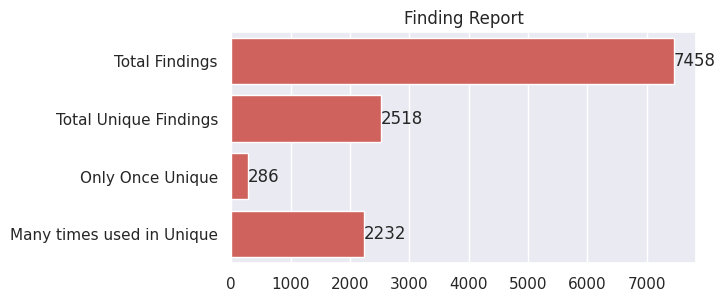

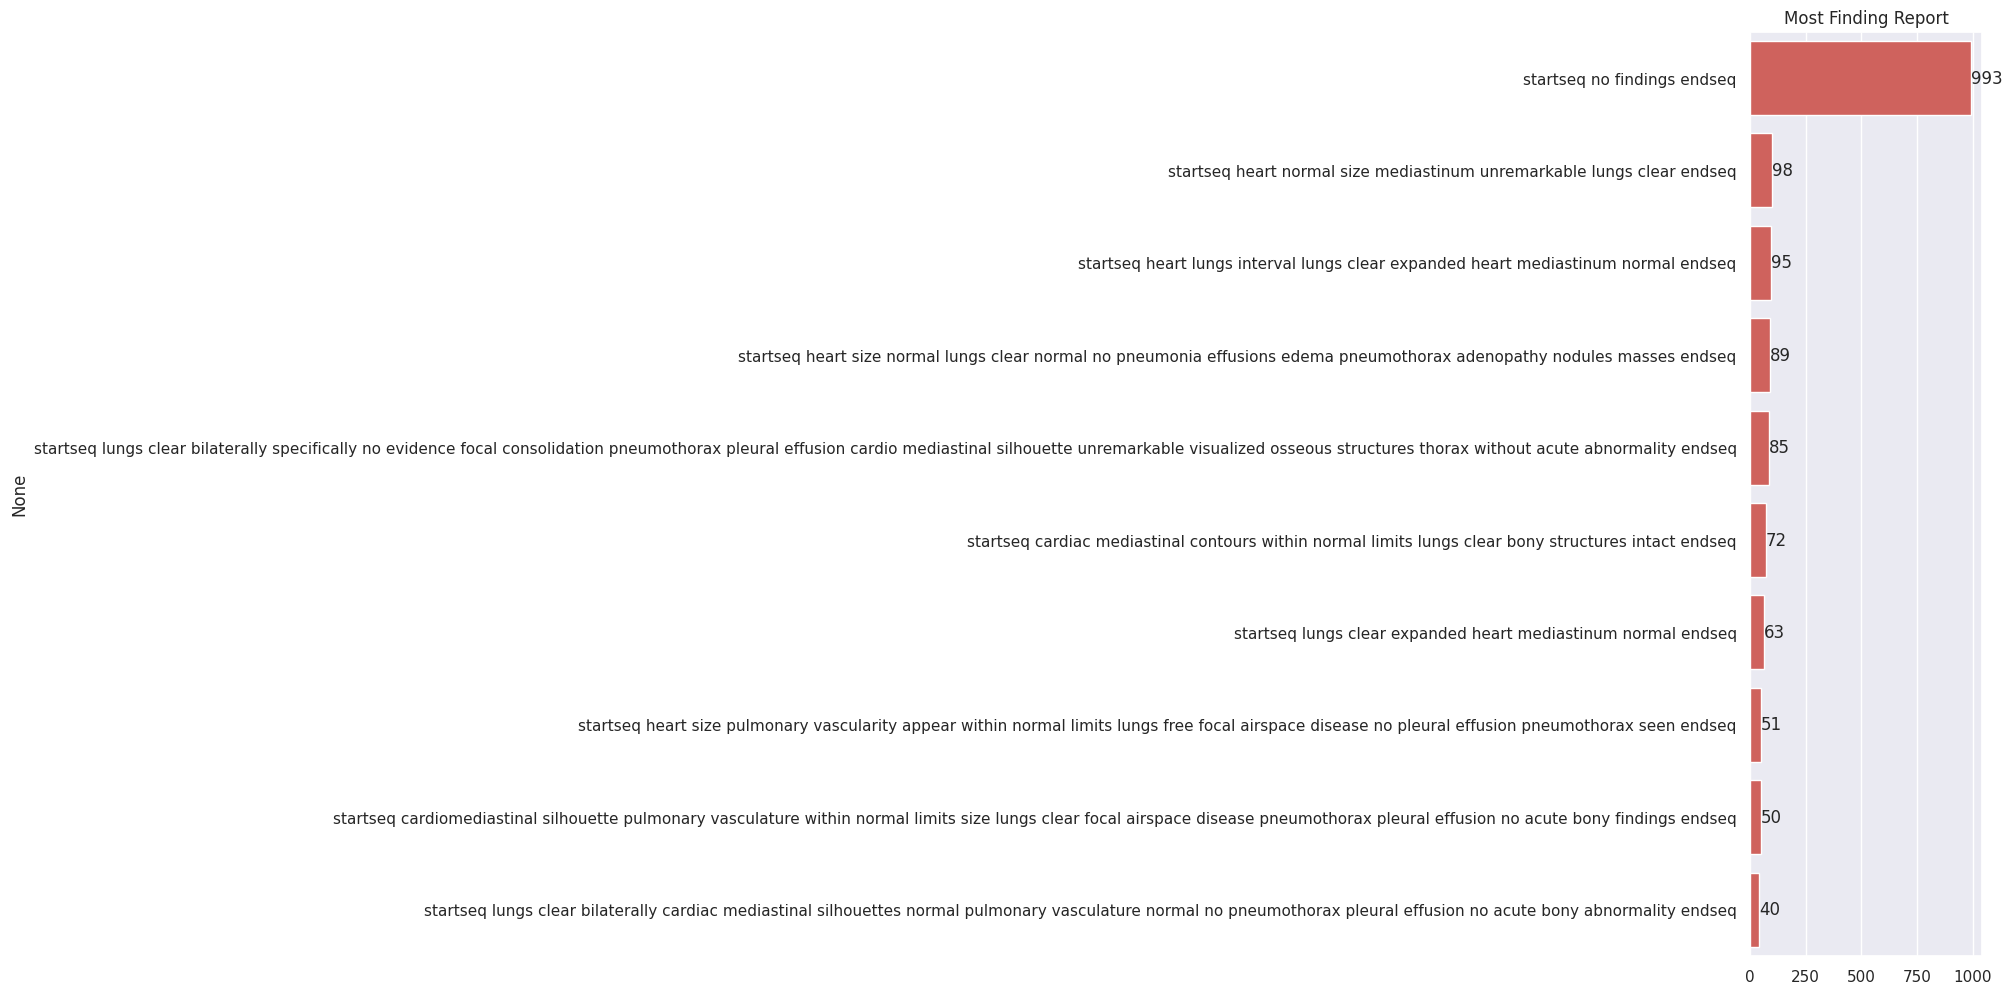

In [ ]:
plot_unique_values(df.FINDING,bar_title='Finding Report')
plot_most_values(df.FINDING,bar_title="Most Finding Report")

In [ ]:
df.FINDING.value_counts(normalize=True,ascending=False)[:10].to_dict()

{'startseq no findings endseq': 0.13314561544650041,
 'startseq heart normal size mediastinum unremarkable lungs clear endseq': 0.013140252078305176,
 'startseq heart lungs interval lungs clear expanded heart mediastinum normal endseq': 0.01273799946366318,
 'startseq heart size normal lungs clear normal no pneumonia effusions edema pneumothorax adenopathy nodules masses endseq': 0.01193349423437919,
 'startseq lungs clear bilaterally specifically no evidence focal consolidation pneumothorax pleural effusion cardio mediastinal silhouette unremarkable visualized osseous structures thorax without acute abnormality endseq': 0.011397157414856529,
 'startseq cardiac mediastinal contours within normal limits lungs clear bony structures intact endseq': 0.009654062751407884,
 'startseq lungs clear expanded heart mediastinum normal endseq': 0.008447304907481898,
 'startseq heart size pulmonary vascularity appear within normal limits lungs free focal airspace disease no pleural effusion pneumoth

In [ ]:
df["WORD_COUNT"] = df["FINDING"].apply(lambda row:len(row.split()))

q3: 26.0 	q1: 14.0
Up limit: 44 	Low limit: 0
Anomalies: Upper: (185, 4) 	Lower: (0, 4)


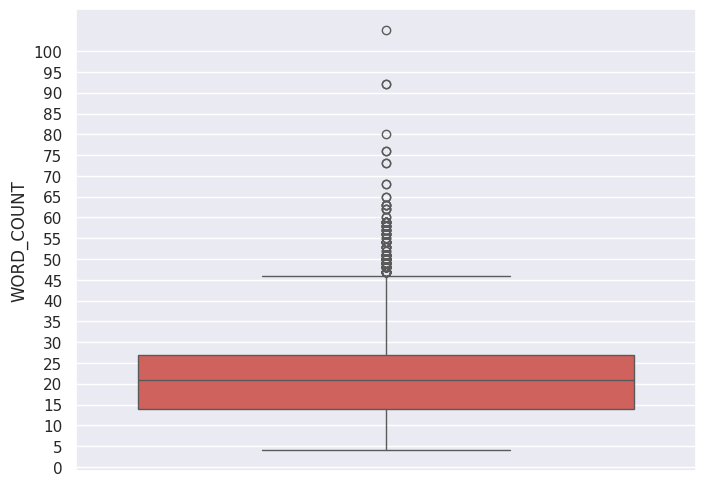

In [ ]:
def calculate_iqr(df,col,q1_ratio=.25,q3_ratio=.75):
  plt.figure(figsize=(8,6))
  sns.boxplot(df[col])
  plt.yticks(np.arange(0,max(df[col].values),5))
  q1 = df[col].quantile(q1_ratio)
  q3 = df[col].quantile(q3_ratio)
  print("q3:",q3,"\tq1:",q1)
  iqr = q3 - q1
  up_limit = round(q3 + (1.5 * iqr))
  low_limit = round(q1 - (1.5 * iqr))
  low_limit =  0 if low_limit <0 else low_limit
  df_is_upper = df[df[col] > up_limit]
  df_is_lower = df[df[col] < low_limit]
  print("Up limit:",up_limit,"\tLow limit:",low_limit)
  print("Anomalies: Upper:",df_is_upper.shape,"\tLower:",df_is_lower.shape)
  return up_limit,low_limit

up_limit,low_limit = calculate_iqr(df,col='WORD_COUNT',q1_ratio=.25,q3_ratio=.70)

<Axes: ylabel='WORD_COUNT'>

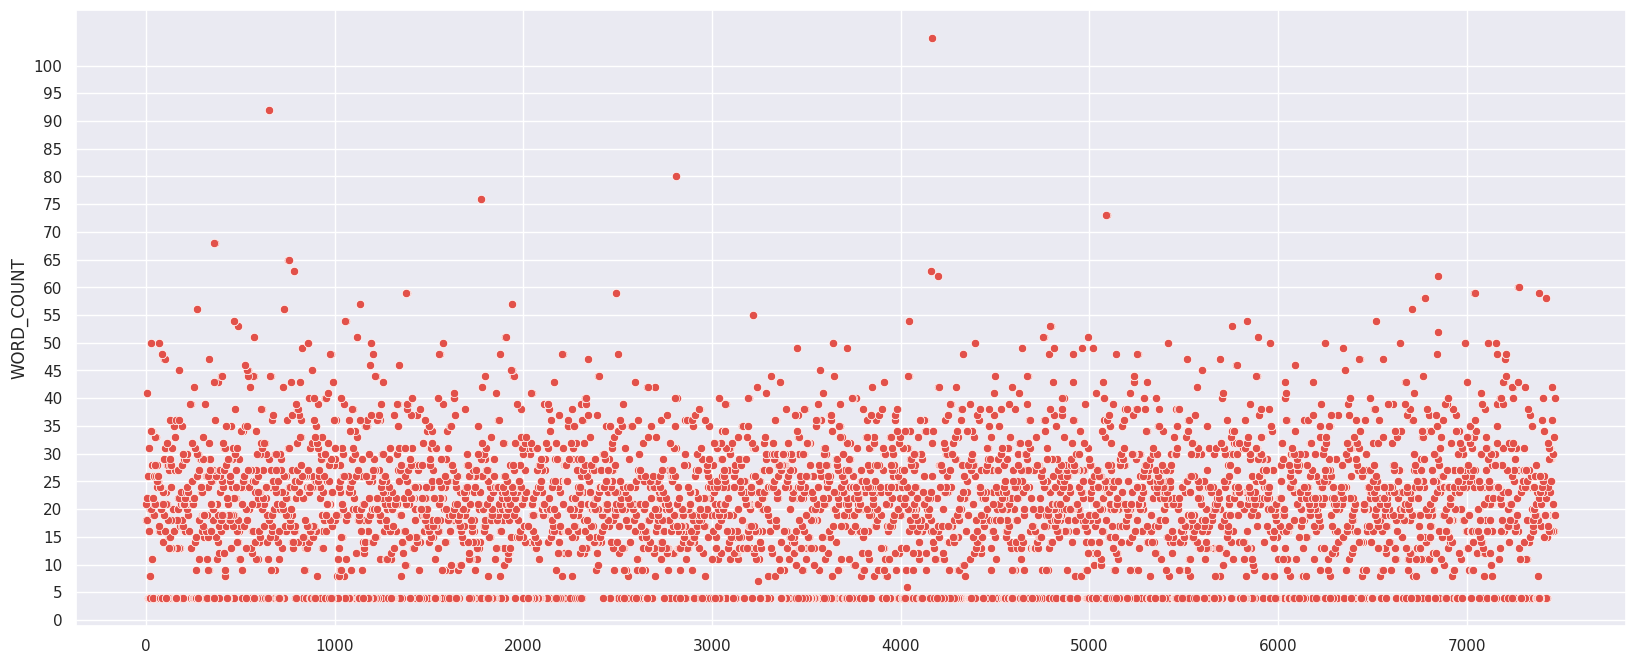

In [ ]:
plt.figure(figsize=(20,8))
data = df.sort_values('WORD_COUNT')["WORD_COUNT"]
plt.yticks(np.arange(0,max(data.values),5))
sns.scatterplot(data)

In [ ]:
df2 = df[(df["WORD_COUNT"] < up_limit) & (df["WORD_COUNT"] > low_limit )]

# Create & Save Tokenizer  


In [ ]:
sentences = df2.FINDING.unique().tolist()
sentences[:5]

['startseq heart size mediastinal contours appear within normal limits no focal airspace consolidation pleural effusion pneumothorax no acute bony abnormalities endseq',
 'startseq mediastinal contours normal unchanged opacity left lung base scarring lungs clear no pneumothorax large pleural effusion endseq',
 'startseq heart size upper limits normal pulmonary vascular engorgement appears within limits normal no consolidating airspace disease seen within lungs no pleural effusion pneumothorax bridging syndesmophytes noted throughout visualized thoracolumbar spine could indicate diffuse idiopathic skeletal hyperostosis similar prior imaging endseq',
 'startseq cardiomediastinal silhouette normal size contour no focal consolidation pneumothorax large pleural effusion negative acute displaced rib fracture bilateral nipple jewelry endseq',
 'startseq no findings endseq']

In [ ]:
from keras.preprocessing.text import Tokenizer
from collections import Counter


In [ ]:
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(df2.FINDING.unique().tolist())
tokenizer.word_counts["<unk>"] = 0

In [ ]:
captions_sequences = tokenizer.texts_to_sequences(df2.FINDING.values.tolist()) # sequence'e dönüştür.
n_vocab = len(tokenizer.word_index) + 1
sentence_lengths = [len(sentence.split()) for sentence in sentences]
max_sentence_length = max(sentence_lengths)
min_sentence_length = min(sentence_lengths)
avg_sentence_length = round(sum(sentence_lengths) / len(sentence_lengths))
median_sentence_length = np.median(sentence_lengths)
most_repeated = Counter(sentence_lengths).most_common(1)[0][0]
seq_length = max_sentence_length
print("max_sentence_length:",max_sentence_length)
print("min_sentence_length:",min_sentence_length)
print("avg_sentence_length:",avg_sentence_length)
print("median_sentence_length:",median_sentence_length)
print("most_repeated_sentence_length:",most_repeated)
print("vocabsize:",n_vocab)
print("seq_length:",seq_length)

max_sentence_length: 43
min_sentence_length: 4
avg_sentence_length: 25
median_sentence_length: 24.0
most_repeated_sentence_length: 23
vocabsize: 1423
seq_length: 43


In [ ]:
words = sorted(tokenizer.word_counts.items(),key=lambda x:x[1],reverse=True)
words[:10]

[('no', 3293),
 ('startseq', 2405),
 ('endseq', 2405),
 ('normal', 2374),
 ('pleural', 1806),
 ('pneumothorax', 1747),
 ('effusion', 1654),
 ('heart', 1500),
 ('size', 1379),
 ('focal', 1285)]

([<matplotlib.axis.YTick at 0x7ad5b546dc90>,
 [Text(0, 0, '0'),
  Text(0, 5, '5'),
  Text(0, 10, '10'),
  Text(0, 15, '15'),
  Text(0, 20, '20'),
  Text(0, 25, '25'),
  Text(0, 30, '30'),
  Text(0, 35, '35'),
  Text(0, 40, '40')])

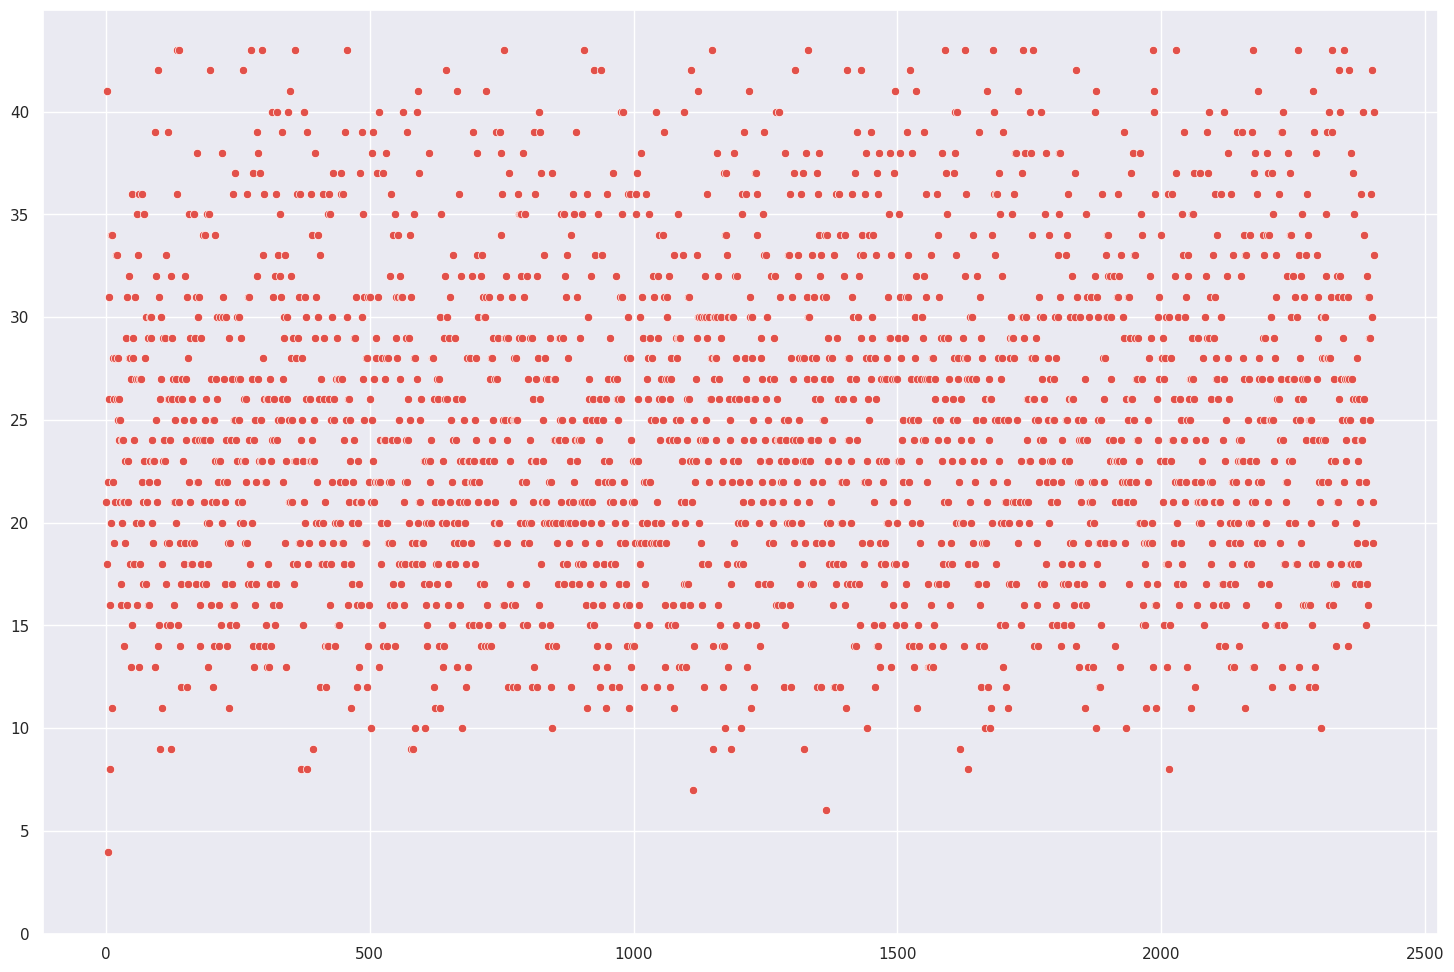

In [ ]:
plt.figure(figsize=(18,12))
sns.scatterplot(sentence_lengths)
plt.yticks(np.arange(0,max(sentence_lengths),5))

In [ ]:
vocabulary = list(tokenizer.word_index.keys())

In [ ]:
df_word = pd.DataFrame.from_records([{'word':word,'freq':tokenizer.word_counts[word]} for word in vocabulary]).sort_values('freq',ascending=False)
df_word.head()

,word,freq
1,no,3293
2,startseq,2405
3,endseq,2405
4,normal,2374
5,pleural,1806


[Text(0, 0, '3293'),
 Text(0, 0, '2405'),
 Text(0, 0, '2405'),
 Text(0, 0, '2374'),
 Text(0, 0, '1806'),
 Text(0, 0, '1747'),
 Text(0, 0, '1654'),
 Text(0, 0, '1500'),
 Text(0, 0, '1379'),
 Text(0, 0, '1285'),
 Text(0, 0, '1210'),
 Text(0, 0, '1000'),
 Text(0, 0, '968'),
 Text(0, 0, '913'),
 Text(0, 0, '846'),
 Text(0, 0, '797'),
 Text(0, 0, '757'),
 Text(0, 0, '674'),
 Text(0, 0, '647'),
 Text(0, 0, '642')]

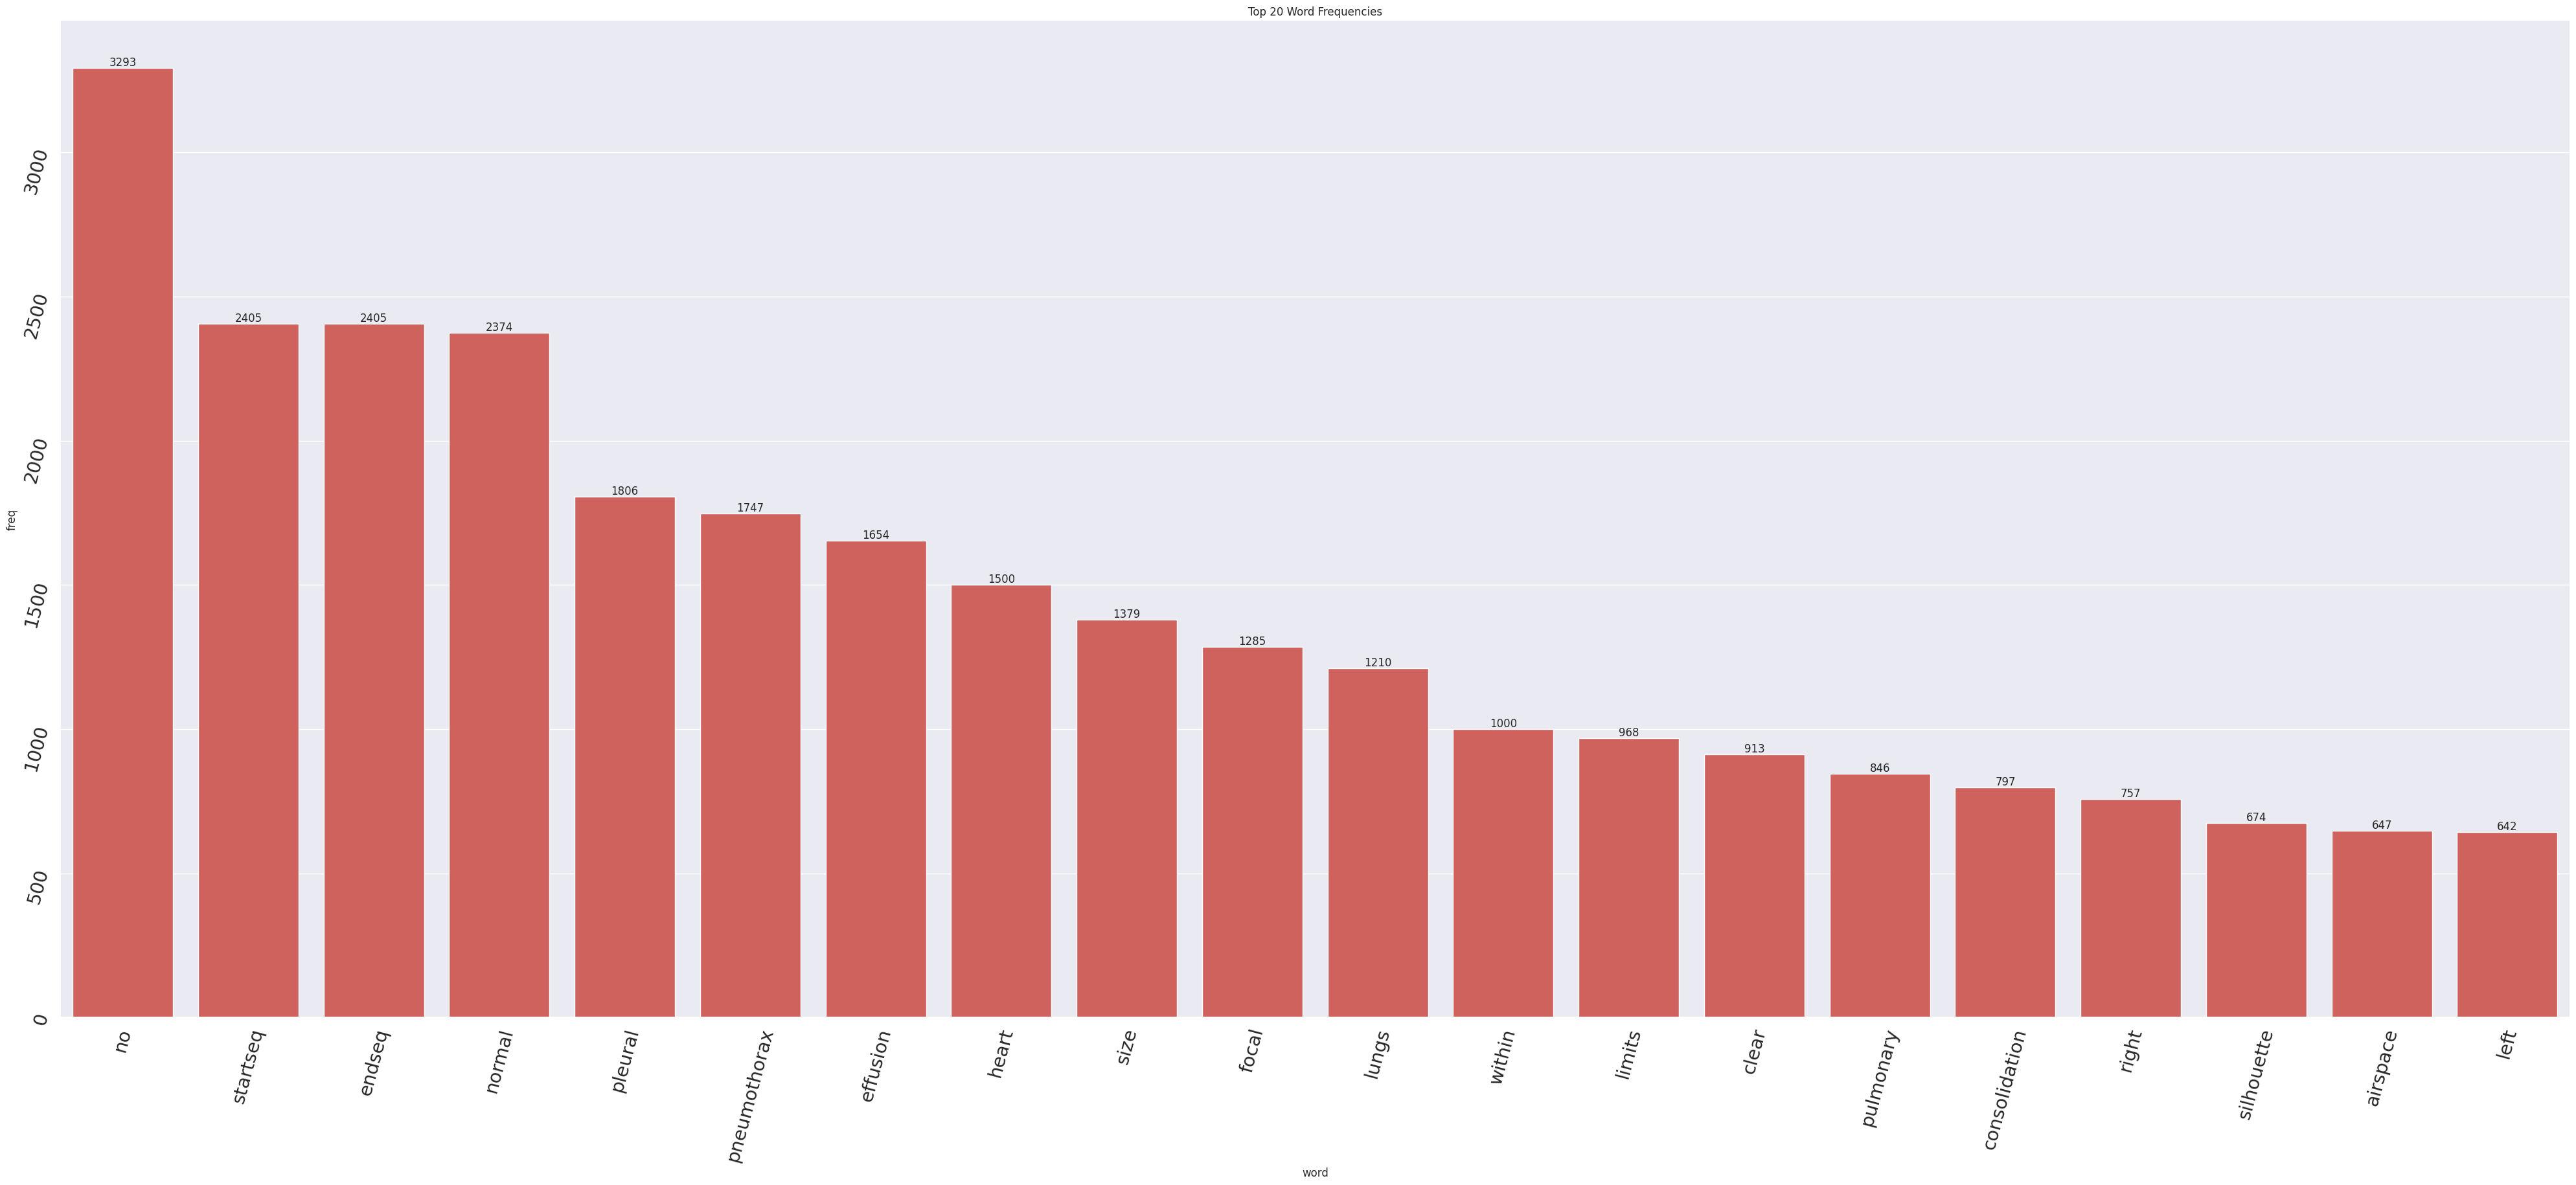

In [ ]:
plt.figure(figsize=(50,20))
plt.title("Top 20 Word Frequencies")
plt.xticks(rotation=75,fontsize='xx-large')
plt.yticks(rotation=75,fontsize='xx-large')
ax = sns.barplot(data=df_word.iloc[:20].sort_values('freq',ascending=False),x='word',y='freq')
ax.bar_label(ax.containers[0])

In [ ]:
from wordcloud import WordCloud

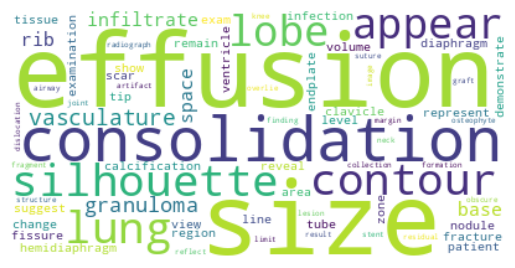

In [ ]:
word_cloud = WordCloud(collocations=False,background_color='white').generate(" ".join(vocabulary))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
dc.write_pkl(data=tokenizer,filename="/content/drive/MyDrive/ChestXAI/models/tokenizer.pkl")

[INFO] Writing final dataset with image features to /content/drive/MyDrive/ChestXAI/models/tokenizer.pkl
[OK] /content/drive/MyDrive/ChestXAI/models/tokenizer.pkl is saved


# Create Model > Train > Save

In [ ]:
tokenizer = dc.load_pkl(filepath="/content/drive/MyDrive/ChestXAI/models/tokenizer.pkl")

In [ ]:
from keras.utils import pad_sequences,to_categorical

In [ ]:
def split_data(df: pd.DataFrame, test_size: float,seed=42) -> dict:
  np.random.seed(seed)
  df_temp = df.copy()
  test_row_count = int(df_temp.shape[0] * test_size)
  test_idx = set()
  while True:
      if len(test_idx) < test_row_count:
          val = np.random.randint(df_temp.shape[0])
          test_idx.add(val)
      else:
          break

  test_idx = df_temp.index.isin(test_idx)
  train_idx = df_temp.index.isin([idx for idx in df_temp.index if idx not in test_idx])
  train_features = df['FEATURE'][train_idx].values
  train_sentences = df_temp["FINDING"][train_idx].values
  test_features = df['FEATURE'][test_idx].values
  test_sentences = df_temp["FINDING"][test_idx].values

  dct = {'train': {'features': train_features, 'sentences': train_sentences},
          'test': {'features': test_features, 'sentences': test_sentences}}

  for k,v in dct.items():
    for k2,v2 in dct[k].items():
      print(f"Dataset {k} > {k2}.shape:{v2.shape}")
  return dct

def create_sequence_data(image_features:np.ndarray,image_findings:np.ndarray,seq_length:int,n_vocab:int):
   image_arr = []
   sequence_arr = []
   output_arr = []
   for img_feature,img_finding in zip(image_features,image_findings):
    curr_seq = tokenizer.texts_to_sequences([img_finding])[0]
    for idx in range(1,len(curr_seq)):
      in_seq = curr_seq[:idx]
      next_word = curr_seq[idx]

      in_seq = pad_sequences([in_seq],maxlen=seq_length)[0]
      out_seq = to_categorical([next_word],num_classes=n_vocab)[0]

      image_arr.append(img_feature)
      sequence_arr.append(in_seq)
      output_arr.append(out_seq)

   image_arr = np.array(image_arr)
   seq_arr = np.array(sequence_arr)
   out_arr = np.array(output_arr)
   return image_arr,seq_arr,out_arr

In [ ]:
data = split_data(df=df2,test_size=.2)

Dataset train > features.shape:(7238,)
Dataset train > sentences.shape:(7238,)
Dataset test > features.shape:(1392,)
Dataset test > sentences.shape:(1392,)


In [ ]:
X_train_images,X_train_sentences,y_train = create_sequence_data(image_features=data["train"]["features"],image_findings=data["train"]["sentences"],seq_length=seq_length,n_vocab=n_vocab)

In [ ]:
X_test_images,X_test_sentences,y_test = create_sequence_data(image_features=data["test"]["features"],image_findings=data["test"]["sentences"],seq_length=seq_length,n_vocab=n_vocab)

In [ ]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input,Dense,LSTM,Embedding,Dropout,concatenate,GlobalAveragePooling2D,Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [ ]:
def define_model(n_vocab:int, sequence_length:int,save_model=True):
  # Encoder
  image_features_input = Input(shape=(4096,),name="ImageInput")
  image_features_out = Dropout(0.5)(image_features_input)
  image_features_out = Dense(256, activation='relu',name="ImageFinal")(image_features_out)

  sequence_input = Input(shape=(sequence_length,),name="SentenceInput")
  sequence_out = Embedding(n_vocab, 256, mask_zero=True)(sequence_input)
  sequence_out = Dropout(0.5)(sequence_out)
  sequence_out = LSTM(256)(sequence_out)

  # Decoder
  decoder_out = concatenate([image_features_out, sequence_out],axis=1)
  decoder_out = Dense(256, activation='relu')(decoder_out)
  outputs = Dense(n_vocab, activation='softmax')(decoder_out)

  model = Model(inputs=[image_features_input, sequence_input], outputs=outputs)
  optim = Adam(lr=1e-4)
  model.compile(loss='categorical_crossentropy', optimizer=optim)

  # summarize model
  print(model.summary())
  if save_model:plot_model(model, to_file='model.png', show_shapes=True)
  return model

def train(data:dict,n_vocab:int,sequence_length:int,epochs=5,batch_size=128):
  print("Training...")
  data_train, data_test = data["train"], data["test"]

  X_train_image = np.squeeze(data_train["image_features"])
  print("Shape XTRAIN IMAGE:",X_train_image.shape)
  X_train_finding = data_train["findings"]
  print("Shape XTRAIN FINDING:",X_train_finding.shape)
  y_train = data_train["outputs"]

  X_test_image = np.squeeze(data_test["image_features"])
  X_test_finding = data_test["findings"]
  y_test = data_test["outputs"]

  model = define_model(n_vocab=n_vocab,sequence_length=sequence_length)
  model_filepath =  "/content/drive/MyDrive/ChestXAI/models/" + 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
  checkpoint = ModelCheckpoint(model_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  model.fit([X_train_image, X_train_finding], y_train, epochs=epochs, batch_size=batch_size,
            validation_data=([X_test_image, X_test_finding], y_test),callbacks=[checkpoint])

In [ ]:
data = {'train':{'image_features':X_train_images,'findings':X_train_sentences,'outputs':y_train},
        'test':{'image_features':X_test_images,'findings':X_test_sentences,'outputs':y_test}}

train(data,n_vocab,seq_length,epochs=5,batch_size=64)

Training...
Shape XTRAIN IMAGE: (139326, 4096)
Shape XTRAIN FINDING: (139326, 43)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 SentenceInput (InputLayer)  [(None, 43)]                 0         []                            
                                                                                                  
 ImageInput (InputLayer)     [(None, 4096)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 43, 256)              364288    ['SentenceInput[0][0]']       
                                                                                                  
 dropout_2 (Dropout)         (None, 4096)                 0         ['ImageInput[0][0]']          
          

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2177/2177 [==============================] - 298s 131ms/step - loss: 2.8761 - val_loss: 2.0235
Epoch 2/5
2177/2177 [==============================] - ETA: 0s - loss: 1.8816
Epoch 2: val_loss improved from 2.02354 to 1.57648, saving model to /content/drive/MyDrive/ChestXAI/dataset/model-ep002-loss1.882-val_loss1.576.h5
2177/2177 [==============================] - 273s 126ms/step - loss: 1.8816 - val_loss: 1.5765
Epoch 3/5
2177/2177 [==============================] - ETA: 0s - loss: 1.5441
Epoch 3: val_loss improved from 1.57648 to 1.27301, saving model to /content/drive/MyDrive/ChestXAI/dataset/model-ep003-loss1.544-val_loss1.273.h5
2177/2177 [==============================] - 271s 125ms/step - loss: 1.5441 - val_loss: 1.2730
Epoch 4/5
2177/2177 [==============================] - ETA: 0s - loss: 1.3111
Epoch 4: val_loss improved from 1.27301 to 1.04485, saving model to /content/drive/MyDrive/ChestXAI/dataset/model-ep004-loss1.311-val_loss1.045.h5
2177/2177 [=============================

# Create a report for an image

In [ ]:
img_to_array(load_img("/content/drive/MyDrive/ChestXAI/dataset/images/CXR1008_IM-0009-4004.png")).shape

(420, 512, 3)

In [ ]:
224 *224

50176

In [ ]:
def extract_an_image_feature(model, img_path) -> np.ndarray:
  print("extracting image features...")
  img = load_img(img_path, target_size=(224, 224))
  img = img_to_array(img)
  w, h, ch = img.shape[0], img.shape[1], img.shape[2]
  img = img.reshape((1, w, h, ch))
  img = preprocess_input(img)
  feature = model.predict(img, verbose=0)
  return feature

def generate_report(img_filepath,extraction_model,prediction_model,tokenizer,seq_length=43):
  img_features = extract_an_image_feature(extraction_model,img_filepath)
  print("generating report")
  n_vocab = len(tokenizer.word_index) + 1
  in_text = 'startseq'
  # iterate over the whole length of the sequence
  for i in range(seq_length):
    # integer encode input sequence
    sequence = tokenizer.texts_to_sequences([in_text])[0]
    # pad input
    sequence = pad_sequences([sequence], maxlen=seq_length)
    # predict next word
    yhat = prediction_model.predict([img_features,sequence],verbose=0)
    # convert probability to integer
    yhat = np.argmax(yhat)
    # map integer to word
    word = tokenizer.index_word[yhat]
    # stop if we cannot map the word
    if word is None or word =='endseq':
      in_text += ' ' + word
      break
    else:
      in_text += ' ' + word

  pred_text = in_text.replace('<unk>',' ')
  pred_text  = pred_text.replace('startseq ','')
  pred_text = pred_text.replace(' endseq','.').split()
  pred_text = ' '.join([pred_text[0].capitalize()] + pred_text[1:])

  return pred_text



In [ ]:
from keras.models import load_model
prediction_model = load_model("/content/drive/MyDrive/ChestXAI/models/model-ep005-loss1.126-val_loss0.891.h5")

In [ ]:
os.listdir("/content/drive/MyDrive/ChestXAI/dataset/images")[:3]

['CXR1008_IM-0009-4004.png',
 'CXR3312_IM-1586-1001.png',
 'CXR2581_IM-1079-1001.png']

In [ ]:
generate_report(img_filepath="/content/drive/MyDrive/ChestXAI/dataset/images/CXR1008_IM-0009-4004.png",
                extraction_model=extract_model,
                prediction_model=prediction_model,
                tokenizer=tokenizer)

extracting image features...


'Heart size mediastinal contours appear within normal limits pulmonary vascularity within normal limits no focal consolidation suspicious pulmonary opacity pneumothorax definite pleural effusion visualized osseous structures appear intact.'

In [ ]:
generate_report(img_filepath="/content/drive/MyDrive/ChestXAI/dataset/images/CXR3312_IM-1586-1001.png",
                extraction_model=extract_model,
                prediction_model=prediction_model,
                tokenizer=tokenizer)

extracting image features...


'Heart size mediastinal contours appear within normal limits pulmonary vascularity within normal limits no focal consolidation suspicious pulmonary opacity pneumothorax definite pleural effusion visualized osseous structures appear intact.'

# Evaluate Model

# Fine Tuning
- Stacked Feature Extracting
- Complex Model
- More epochs
- Bigger LR

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

def create_feature_extractor_model_mobile_net():
  extract_model_filepath = "/content/drive/MyDrive/ChestXAI/models/mobilenet.pkl"
  input_shape = (224,224,3)
  input_layer = Input(shape = input_shape)

  mobilenet_base = MobileNetV2(weights = "imagenet",input_shape = input_shape,include_top = False)
  for layer in mobilenet_base.layers:
    layer.trainable = False

  model_mobilenet = mobilenet_base(input_layer)
  model_mobilenet = GlobalAveragePooling2D()(model_mobilenet)
  output_mobilenet = Flatten()(model_mobilenet)
  dc.write_pkl(data=extract_model,filename=extract_model_filepath)

create_feature_extractor_model_mobile_net()

AttributeError: 'KerasTensor' object has no attribute 'save'